<a href="https://colab.research.google.com/github/czs-school-23/bayesian-ml/blob/main/stellar_spectra_example_emily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup
Firstly, let's import everything we'll need.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import os
from pathlib import Path
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from scipy.stats import iqr as interquartile_range
from scipy.stats import gaussian_kde
from scipy.signal import medfilt
from scipy.fft import fft, rfft

Next, we need to download the repository containing our data.

In [53]:
!git clone "https://github.com/czs-school-23/bayesian-ml"
os.chdir("bayesian-ml")

Cloning into 'bayesian-ml'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 9), reused 17 (delta 3), pack-reused 0
Receiving objects: 100% (32/32), 6.22 MiB | 17.73 MiB/s, done.
Resolving deltas: 100% (9/9), done.


Now, let's load the data we'll be using.

In [54]:
list(Path(".").glob("data/*/*"))

[PosixPath('data/curve/curve.py'),
 PosixPath('data/curve/curve.png'),
 PosixPath('data/curve/data.npy'),
 PosixPath('data/stellar_spectra/spectra.npy'),
 PosixPath('data/stellar_spectra/wavelengths.npy'),
 PosixPath('data/stellar_spectra/properties.csv')]

In [55]:
spectra = np.load("data/stellar_spectra/spectra.npy")
properties = pd.read_csv("data/stellar_spectra/properties.csv")

# In log angstroms by default. Converted to nm because personal preference =)
wavelengths = np.exp(np.load("data/stellar_spectra/wavelengths.npy")) / 10

# Inspecting the data
Let's take a look at what we're working with!

These are the parameters of the first five spectra:

In [56]:
properties.head()

,t_eff,log_g,feh,afe,v_mic,phase,age,v_macro,h_abundance,he_abundance,filename
0,4932.1777,4.274360,0.5,0.419682,3.008605,-1,7.10,0.0,0.914398,0.079920,b'X0000'
1,4670.5576,0.960434,0.5,-0.099054,2.158830,0,7.15,0.0,0.919236,0.078108,b'X0001'
2,6180.6104,4.077509,0.5,0.323485,3.652777,-1,7.20,0.0,0.915778,0.079401,b'X0002'
3,6798.6284,4.111562,0.5,0.336346,2.158780,0,7.20,0.0,0.915610,0.079464,b'X0003'
4,4129.8010,0.905774,0.5,0.176030,1.875668,0,7.20,0.0,0.917379,0.078801,b'X0004'


## Histograms

These are overall histograms of the parameters we'd like to fit: t_eff, log_g, and feh.

<Axes: >

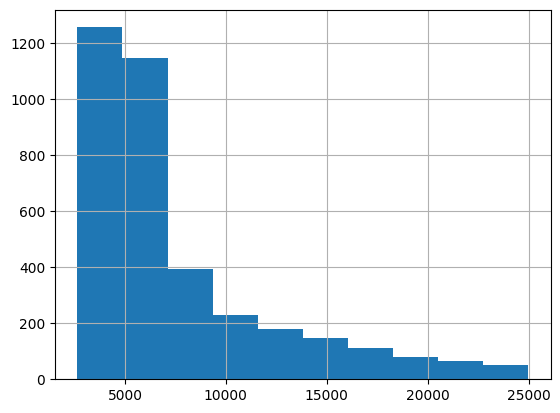

In [57]:
properties['t_eff'].hist()

<Axes: >

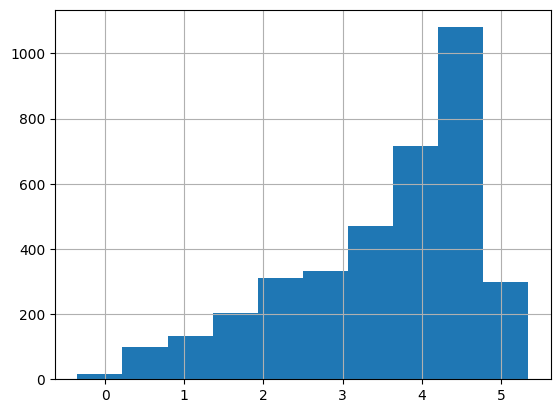

In [58]:
properties['log_g'].hist()

<Axes: >

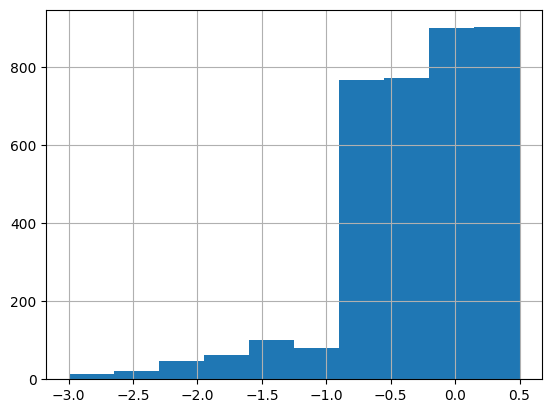

In [59]:
properties['feh'].hist()

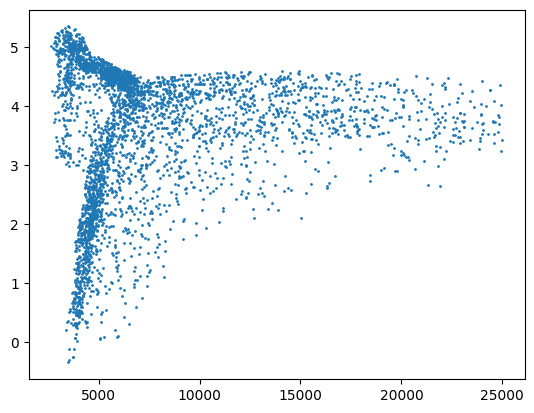

In [60]:
plt.scatter(properties["t_eff"], properties["log_g"], s=1)

## Spectra
Here are a few of the spectra, plotted to have the same area:

Text(0.5, 0, 'Wavelength (nm)')

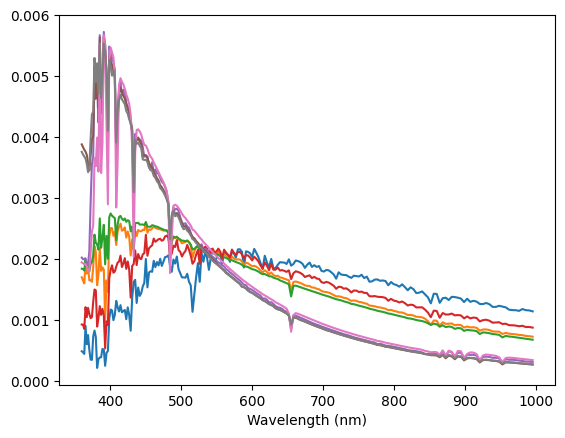

In [61]:
for s in spectra[::500]:
  plt.plot(wavelengths, s / np.trapz(s, wavelengths))

plt.xlabel("Wavelength (nm)")

# Preprocessing
Before going any further, we should standardise all the spectral data a bit.

We'll give everything a zero median and unit inter-quartile range (a bit more robust than zero mean unit variance).

In [75]:
input_scaler = RobustScaler()
output_scaler = RobustScaler()

x = spectra.copy()
y = properties[["t_eff", "log_g", "feh"]].to_numpy().copy()

# Scale pixel value-wise
# x_scaled = input_scaler.fit_transform(x)

# Scale spectra-wise
# x_scaled = (x - np.median(x, axis=1).reshape(-1, 1)) / interquartile_range(x, axis=1).reshape(-1, 1)
x = x / interquartile_range(x, axis=1).reshape(-1, 1)
x_scaled = np.asarray([s - medfilt(s, 21) for s in x])
# x_scaled = np.asarray([s - medfilt(s, 21) for s in x_scaled])

# Median filtering
#x_scaled = np.asarray([s - medfilt(s, 21) for s in x])
#x_scaled = input_scaler.fit_transform(x)


y_scaled = output_scaler.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, random_state=42, train_size=0.8)

Text(0.5, 0, 'Wavelength (nm)')

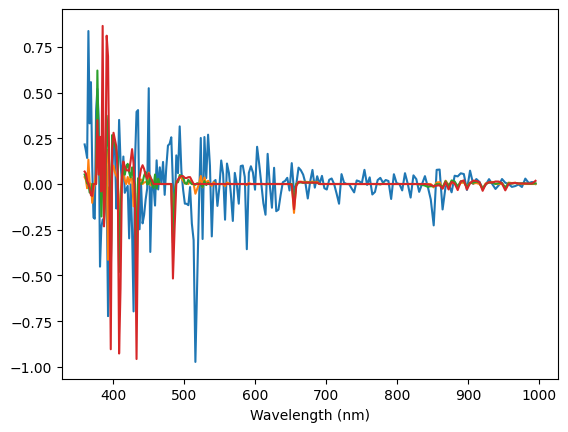

In [76]:
for s in x_scaled[::1000]:
    plt.plot(wavelengths, s)

plt.xlabel("Wavelength (nm)")

In [77]:
# We can also compute some optional sample weights based on how common each feature is.
kernel = gaussian_kde(y_train.T)
training_weights = 1 / kernel(y_train.T)

# We rescale these weights to have a total value equal to the overall dataset
training_weights = training_weights / training_weights.sum() * x_train.shape[0]

In [78]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2928, 210), (732, 210), (2928, 3), (732, 3))

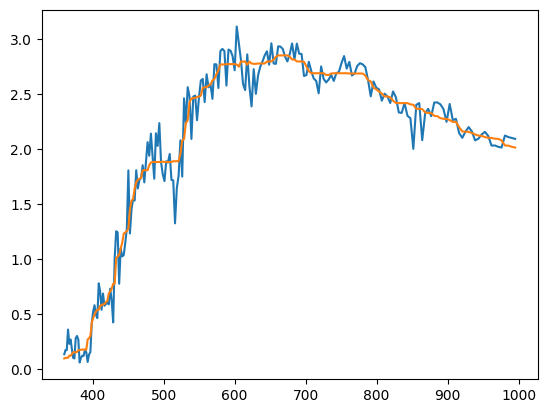

In [79]:
i = 10

plt.plot(wavelengths, x[i])
plt.plot(wavelengths, medfilt(x[i], 21))

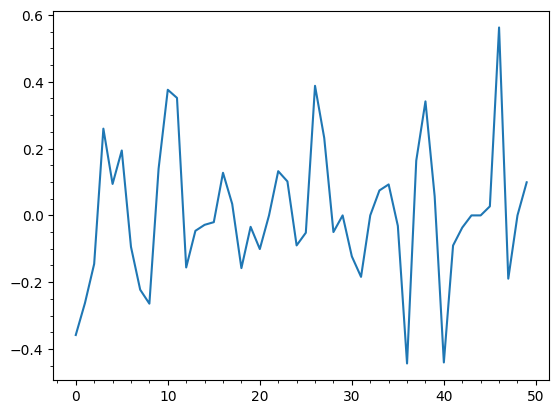

In [18]:
plt.plot(np.arange(210)[:50], x_scaled[1][:50])
plt.gca().minorticks_on()

We have about 3000 examples to train on and 730 to test on.

# A basic network
Let's try making a basic network to infer properties with these spectra.

In [107]:
model = keras.Sequential([
    keras.layers.Reshape((210, 1)),
    keras.layers.Convolution1D(40, 7, 2, activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dense(3)
])

In [108]:
model.compile(
    loss="MeanSquaredError",
    metrics=['MeanSquaredError'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)],
    epochs=300,
    verbose=1
)

Epoch 1/300
92/92 [==============================] - 2s 7ms/step - loss: 0.5592 - mean_squared_error: 0.5592 - val_loss: 0.3874 - val_mean_squared_error: 0.3874
Epoch 2/300
92/92 [==============================] - 0s 5ms/step - loss: 0.3176 - mean_squared_error: 0.3176 - val_loss: 0.2578 - val_mean_squared_error: 0.2578
Epoch 3/300
92/92 [==============================] - 0s 5ms/step - loss: 0.2280 - mean_squared_error: 0.2280 - val_loss: 0.1912 - val_mean_squared_error: 0.1912
Epoch 4/300
92/92 [==============================] - 0s 5ms/step - loss: 0.1766 - mean_squared_error: 0.1766 - val_loss: 0.1514 - val_mean_squared_error: 0.1514
Epoch 5/300
92/92 [==============================] - 0s 5ms/step - loss: 0.1528 - mean_squared_error: 0.1528 - val_loss: 0.1316 - val_mean_squared_error: 0.1316
Epoch 6/300
92/92 [==============================] - 0s 5ms/step - loss: 0.1373 - mean_squared_error: 0.1373 - val_loss: 0.1221 - val_mean_squared_error: 0.1221
Epoch 7/300
92/92 [===============

In [109]:
y_predicted = output_scaler.inverse_transform(model(x_test))
y_targets = output_scaler.inverse_transform(y_test)

[Text(0.5, 1.0, '[Fe/H]')]

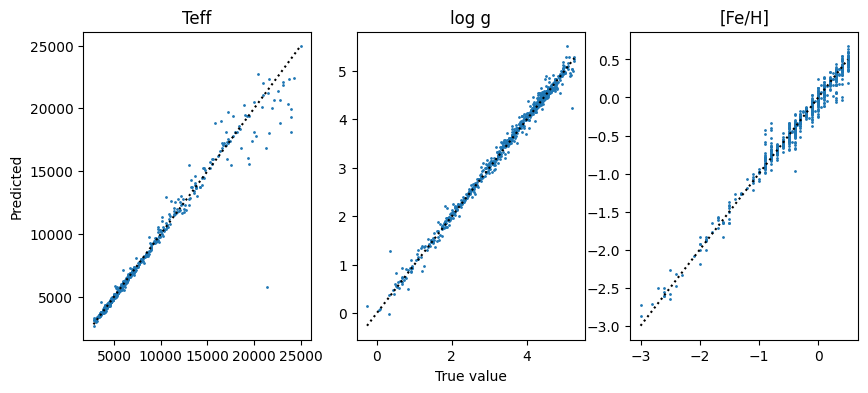

In [110]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 4))

for i in range(3):
    ax[i].scatter(y_targets[:, i], y_predicted[:, i], s=1)
    min, max = y_targets[:, i].min(), y_targets[:, i].max()
    ax[i].plot([min, max], [min, max], 'k:')

ax[0].set(title="Teff", ylabel="Predicted")
ax[1].set(title="log g", xlabel="True value")
ax[2].set(title="[Fe/H]")

# Bayesianifying it with Flipout

In [89]:
@tf.function
def kl_divergence(q, p, _):
    return tfp.distributions.kl_divergence(q, p) / tf.cast(x_train.shape[0], dtype=tf.float32) / 4300

@tf.function
def negative_loglikelihood(y, estimated_distribution):
    return -estimated_distribution.log_prob(y)

@tf.function
def mean_squared_error(y, estimated_distribution):
    return (estimated_distribution.mean() - y)**2

def get_model(input_shape=210):
    input = keras.layers.Input(shape=(input_shape,))
    x = keras.layers.Reshape((input_shape, 1))(input)

    flipout_config = dict(
        kernel_divergence_fn=kl_divergence,
        bias_divergence_fn=kl_divergence
    )

    # Main parts of the network
    x = tfp.layers.Convolution1DFlipout(40, 11, 2, activation="relu", **flipout_config)(x)

    x = keras.layers.Flatten()(x)
    #x = tfp.layers.DenseFlipout(200, activation="relu", kernel_divergence_fn=kl_divergence, bias_divergence_fn=kl_divergence)(x)
    x = tfp.layers.DenseFlipout(200, activation="relu", **flipout_config)(x)
    x = tfp.layers.DenseFlipout(100, activation="relu", **flipout_config)(x)

    # Output - we learn 3 means and 3 standard deviations, which each need different activations
    means = tfp.layers.DenseFlipout(3, activation=None, **flipout_config)(x)
    standards = tfp.layers.DenseFlipout(3, activation="softplus", **flipout_config)(x)

    parameters = keras.layers.Concatenate()([means, standards])
    output = tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :3], scale=1e-4 + t[..., 3:])  # We add to stop the scale ever being zero; multiply to reduce scale size
    )(parameters)
    # output = tfp.layers.DistributionLambda(
    #     lambda t: tfd.Normal(loc=t[..., :3], scale=1)
    # )(means)

    return keras.Model(inputs=input, outputs=output)

In [93]:
model = get_model()

model.compile(
    loss=negative_loglikelihood,  # the KL divergence of every distribution is added on automatically
    #metrics=[mean_squared_error],
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    #steps_per_execution=batch_size  # ?
)

model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)],
    epochs=500,
    verbose=1,
    # sample_weight=training_weights
    #batch_size=batch_size
)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/500
92/92 [==============================] - 6s 17ms/step - loss: 1.2927 - val_loss: 1.1158
Epoch 2/500
92/92 [==============================] - 1s 9ms/step - loss: 1.0539 - val_loss: 0.9656
Epoch 3/500
92/92 [==============================] - 1s 9ms/step - loss: 0.9563 - val_loss: 0.8795
Epoch 4/500
92/92 [==============================] - 1s 10ms/step - loss: 1.1212 - val_loss: 0.8575
Epoch 5/500
92/92 [==============================] - 1s 9ms/step - loss: 0.8152 - val_loss: 0.7293
Epoch 6/500
92/92 [==============================] - 1s 13ms/step - loss: 0.7552 - val_loss: 0.7276
Epoch 7/500
92/92 [==============================] - 1s 15ms/step - loss: 0.6993 - val_loss: 0.6261
Epoch 8/500
92/92 [==============================] - 1s 10ms/step - loss: 0.6821 - val_loss: 0.6012
Epoch 9/500
92/92 [==============================] - 1s 9ms/step - loss: 0.6137 - val_loss: 0.5688
Epoch 10/500
92/92 [==============================] - 1s 9ms/step - loss: 0.5567 - val_loss: 0.5072
Epoc

In [91]:
model_distributions = model(x_test)
means, stds = model_distributions.mean(), model_distributions.stddev()

y_predicted = output_scaler.inverse_transform(means)
y_error = output_scaler.inverse_transform(means + stds) - y_predicted
y_targets = output_scaler.inverse_transform(y_test)

print(f"Mean squared error: {np.mean((means - y_test)**2):.5f}")

Mean squared error: 0.07702


[Text(0.5, 1.0, '[Fe/H]')]

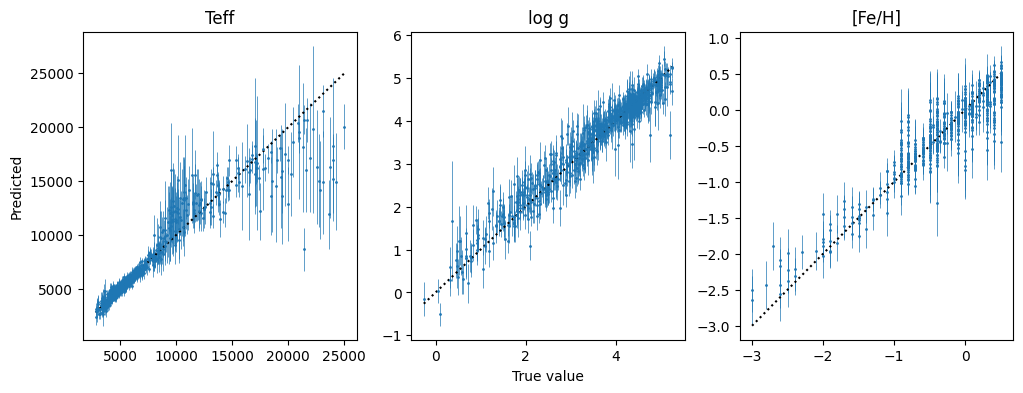

In [92]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

for i in range(3):
    ax[i].errorbar(y_targets[:, i], y_predicted[:, i], fmt='o', ms=1, yerr=y_error[:, i], elinewidth=0.5)
    min, max = y_targets[:, i].min(), y_targets[:, i].max()
    ax[i].plot([min, max], [min, max], 'k:')

ax[0].set(title="Teff", ylabel="Predicted")
ax[1].set(title="log g", xlabel="True value")
ax[2].set(title="[Fe/H]")